In [3]:
import os
import ast
import json
import torch 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

torch.cuda.current_device()
torch.set_default_dtype(torch.float64)


import sys
sys.path.append("../..")
from utils.misc_utils import check_create_folder

from prediction.pred_utils import get_device, transform_data_to_all_steps_prediction, get_name_string, get_NOAA_dataset
from architectures.space_time.parametric_pooling_net_ordering import ParametricNetWithPoolingOrdered
from prediction.NOAA.difference_utils import perform_step_ahead_deltas, invert_difference_graph_signals, \
compute_iteration_rNMSE_with_deltas, visualize_predictions, visualize_deltas

device = get_device(use_gpu=True)

Device selected: cuda:0


In [4]:
def itemize_dictionary(dictionary, round_digits):
    for k,i in dictionary.items():
        dictionary[k] = round(i.item(), round_digits)
    return dictionary

In [5]:
ds_folder = "../"
splits = [0.35, 0.15, 0.5]
obs_window = 4

dataset_differences, steps_ahead, weighted_adjacency = get_NOAA_dataset(
    ds_folder,
    splits=splits,
    obs_window=obs_window,
    differenced=True,
)
trn_data_deltas, val_data_deltas, tst_data_deltas, trn_labels_deltas, val_labels_deltas, tst_labels_deltas = transform_data_to_all_steps_prediction(dataset_differences, node_first=True, device=device)
N_spatial_nodes = weighted_adjacency.shape[0]

orig_dataset, _, _ = get_NOAA_dataset(
    ds_folder,
    splits=splits,
    obs_window=obs_window,
    differenced=False,
)
_, _, _, orig_trn_labels, orig_val_labels, orig_tst_labels = transform_data_to_all_steps_prediction(orig_dataset, node_first=True, device=device)
assert orig_tst_labels.shape[0] == tst_labels_deltas.shape[0] + 1

print(f"{N_spatial_nodes} nodes - {obs_window} observed timesteps - steps ahead: {steps_ahead}\n\n")



NOAA is selected



Dataset path: ..//NOAA/dataset/processed/NOA_w=4_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5]_differenced.pickle


NOAA is selected



Dataset path: ..//NOAA/dataset/processed/NOA_w=4_steps=[1, 2, 3, 4, 5]_splits=[0.35, 0.15, 0.5].pickle
109 nodes - 4 observed timesteps - steps ahead: [1, 2, 3, 4, 5]




# ------------------------------------------------------------------------------------

In [5]:
def pretty_print_dict(dictionary):
    for key in dictionary:
        print(f"{key}: {dictionary[key][1]} --> {dictionary[key][0]}")

In [6]:
# runs_dir = "C:\\Users\\gabri\\Desktop\\exp_prediction_NOAA\\difference_cyclic_acyclic_directed_undirected_tests\\"
runs_dir = "C:\\Users\\gabri\\Desktop\\new_thesis_project\\prediction\\NOAA\\runs_NOAA_w=4_diff=True\\"


model_directories = [x[0] for x in os.walk(runs_dir)][1:]
print(f"{len(model_directories)} models found in directory.")

122 models found in directory.


In [7]:
start = 10
model_directories[0].split("_")[start] # to see at which index we match the features

'F=[4, 8]'

Now, we loop through each model folder and we compute the rNMSE dictionary for each set (trn/val/tst). Then, we save this result in each folder as a json file.

In [8]:
VERBOSE = False
DO_TRAIN = False
REDO_TESTS = False

model_dicts = []

for idx, model_dir in enumerate(model_directories):
    model_name = model_dir.split("\\")[-1]
    
    if idx%10 == 0 or True:
        print("\n")
        print(idx)    
        print(model_name)
        
        
    # check if the model already has the json dictionary saved --> no need to compute it again!
    does_file_exist = os.path.isfile(f'{model_dir}/results.json')
    if does_file_exist and not REDO_TESTS:
        print("Results already computed")
        with open(f'{model_dir}/results.json') as json_file:
            model_dict = json.load(json_file)
            pretty_print_dict(model_dict)
            model_dicts.append((model_name, model_dict))
        continue
    else:
        print("Computing results...")
        
        
    features = ast.literal_eval(model_dir.split("_")[start].split("=")[1])
    taps = ast.literal_eval(model_dir.split("_")[start+1].split("=")[1])
    pool_ratios = ast.literal_eval(model_dir.split("_")[start+2].split("=")[1])
    reach = ast.literal_eval(model_dir.split("_")[start+3].split("=")[1])
    nodes = ast.literal_eval(model_dir.split("_")[start+4].split("=")[1])
    
    
    feat_per_layer = [1] + features
    taps_per_layer = taps
    pool_reach_per_layer = reach
    active_nodes_per_timestep_per_layer = [N_spatial_nodes] + nodes
    time_pooling_ratio_per_layer = pool_ratios
    
    
    
    cyclic_time_graph = 'cyclic=True' in model_dir
    time_directed = 'tdirect=False' not in model_dir
    
    
    one_step_gtcnn = ParametricNetWithPoolingOrdered(
    window=obs_window,
    cyclic_time_graph=cyclic_time_graph,
    time_directed=time_directed,
    S_spatial=weighted_adjacency,
    n_feat_per_layer=feat_per_layer,
    n_taps_per_layer=taps_per_layer,
    n_active_nodes_per_timestep_per_layer=active_nodes_per_timestep_per_layer,
    time_pooling_ratio_per_layer=time_pooling_ratio_per_layer,
    pool_reach_per_layer=pool_reach_per_layer,
    output_dim=N_spatial_nodes,
    device=device)

    one_step_gtcnn.to(device)
    
    checkpoint = torch.load(f"{model_dir}/best_one_step_gtcnn.pth") 

    one_step_gtcnn.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Best model was at epoch: {epoch}")

    one_step_gtcnn.eval()
    
    
    trn_values = None
    if DO_TRAIN:
        # we'll see if we want to compute it for the train set as well (takes time)
        _, cum_delta_pred_dict_trn = perform_step_ahead_deltas(trn_data_deltas, one_step_gtcnn, steps_ahead, verbose=VERBOSE)
        trn_rNMSEs, _ = compute_iteration_rNMSE_with_deltas(
            cumulative_deltas_dict=cum_delta_pred_dict_trn,
            original_one_step_labels=orig_trn_labels[:, 0, :],
            verbose=VERBOSE
        )
        avg_trn_rNMSEs = round(np.average(trn_rNMSEs), 5)
        trn_values = (avg_trn_rNMSEs, trn_rNMSEs)
        
   # validation set
    _, cum_delta_pred_dict_val = perform_step_ahead_deltas(val_data_deltas, one_step_gtcnn, steps_ahead, verbose=VERBOSE)
    val_rNMSEs, _ = compute_iteration_rNMSE_with_deltas(
        cumulative_deltas_dict=cum_delta_pred_dict_val,
        original_one_step_labels=orig_val_labels[:, 0, :],
        verbose=VERBOSE
    )
    avg_val_rNMSEs = round(np.average(val_rNMSEs), 5)
    val_values = (avg_val_rNMSEs, val_rNMSEs)
    
    # test set
    _, cum_delta_pred_dict_tst = perform_step_ahead_deltas(tst_data_deltas, one_step_gtcnn, steps_ahead, verbose=VERBOSE)
    tst_rNMSEs, _ = compute_iteration_rNMSE_with_deltas(
        cumulative_deltas_dict=cum_delta_pred_dict_tst,
        original_one_step_labels=orig_tst_labels[:, 0, :],
        verbose=VERBOSE
    )
    avg_tst_rNMSEs = round(np.average(tst_rNMSEs), 5)
    tst_values = (avg_tst_rNMSEs, tst_rNMSEs)
    

    model_dict = {
        'trn': trn_values if DO_TRAIN else (0, {}),
        'val': val_values,
        'tst': tst_values
    }
    
    model_dicts.append((model_name, model_dict))
    
    pretty_print_dict(model_dict)
    
    with open(f'{model_dir}/results.json', 'w', encoding='utf-8') as f:
        json.dump(model_dict, f, ensure_ascii=False, indent=4)



0
20200226170012_lr=0.01_b=256_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 54]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: {} --> 0
val: [0.0174, 0.0355, 0.0542, 0.068, 0.0791] --> 0.05084
tst: [0.024, 0.0674, 0.1227, 0.1728, 0.213] --> 0.11998


1
20200226173129_lr=0.01_b=256_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 54]_wd=0_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: {} --> 0
val: [0.0196, 0.0421, 0.0771, 0.1219, 0.1663] --> 0.0854
tst: [0.0258, 0.0681, 0.1344, 0.2175, 0.3027] --> 0.1497


2
20200226175816_lr=0.01_b=256_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 54]_wd=0.0025_cyclic=True_r=0_tdirect=True
Results already computed
trn: {} --> 0
val: [0.0222, 0.0467, 0.0726, 0.0986, 0.1281] --> 0.07364
tst: [0.0286, 0.063, 0.1033, 0.1433, 0.1813] --> 0.1039


3
20200226181751_lr=0.01_b=256_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 54]_wd=0.0025_cyclic=True_r=0_tdirect=True
Results already computed
trn: {} --> 0

20200227135726_lr=0.01_b=256_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 76]_wd=0_cyclic=True_r=0_tdirect=True
Results already computed
trn: {} --> 0
val: [0.0181, 0.0369, 0.0586, 0.0789, 0.0934] --> 0.05718
tst: [0.024, 0.0589, 0.1104, 0.1631, 0.2102] --> 0.11332


59
20200227142741_lr=0.01_b=256_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 76]_wd=0_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn: {} --> 0
val: [0.0185, 0.0442, 0.0781, 0.1062, 0.127] --> 0.0748
tst: [0.0269, 0.0723, 0.142, 0.2127, 0.2791] --> 0.1466


60
20200227145647_lr=0.01_b=256_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 76]_wd=0.0025_cyclic=True_r=0_tdirect=True
Results already computed
trn: {} --> 0
val: [0.021, 0.0458, 0.0788, 0.1136, 0.1481] --> 0.08146
tst: [0.0265, 0.0671, 0.1314, 0.2039, 0.2736] --> 0.1405


61
20200227152452_lr=0.01_b=256_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 76]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
Results already computed
trn:

Initialization (random) with gain 0.2
Initialization (random) with gain 0.2


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gabri\\Desktop\\new_thesis_project\\prediction\\NOAA\\runs_NOAA_w=4_diff=True\\20200611131316_lr=0.005_b=256_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 1308]_wd=0_cyclic=True_r=0_tdirect=True/best_one_step_gtcnn.pth'

## Sorting the models

In [9]:
models_sorted_by_trn = sorted(model_dicts, key=lambda item: item[1]['trn'][0])
models_sorted_by_val = sorted(model_dicts, key=lambda item: item[1]['val'][0])
models_sorted_by_tst = sorted(model_dicts, key=lambda item: item[1]['tst'][0])

## Best models on val

In [10]:
for idx, (name, dictionary) in enumerate(models_sorted_by_val[:5]):
    print("\n", idx)
    values = name.split('_')
    print(f"Model: {name}")
    print(values[3])
    pretty_print_dict(dictionary)


 0
Model: 20200226170012_lr=0.01_b=256_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[1, 4]_R=[1, 1]_N=[87, 54]_wd=0_cyclic=True_r=0_tdirect=True
w=4
trn: {} --> 0
val: [0.0174, 0.0355, 0.0542, 0.068, 0.0791] --> 0.05084
tst: [0.024, 0.0674, 0.1227, 0.1728, 0.213] --> 0.11998

 1
Model: 20200227215830_lr=0.01_b=256_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 54]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
w=4
trn: {} --> 0
val: [0.0186, 0.0349, 0.0517, 0.0683, 0.0844] --> 0.05158
tst: [0.0238, 0.0558, 0.0988, 0.1403, 0.1771] --> 0.09916

 2
Model: 20200227011140_lr=0.01_b=256_w=4_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[87, 54]_wd=0_cyclic=True_r=0_tdirect=True
w=4
trn: {} --> 0
val: [0.018, 0.0338, 0.0507, 0.0696, 0.094] --> 0.05322
tst: [0.0266, 0.0619, 0.1112, 0.17, 0.236] --> 0.12114

 3
Model: 20200228051234_lr=0.01_b=256_w=4_L=2_F=[4, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 76]_wd=0_cyclic=True_r=0_tdirect=True
w=4
trn: {} --> 0
val: [0.0179, 0.035, 0.0518, 0.0729, 0.1039] --> 0.0563
ts

# Best models on tst

In [11]:
for idx, (name, dictionary) in enumerate(models_sorted_by_tst[:10]):
    print("\n", idx)
    values = name.split('_')
    print(f"Model: {name}")
    print(values[3])
    pretty_print_dict(dictionary)


 0
Model: 20200228083841_lr=0.01_b=256_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 76]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
w=4
trn: {} --> 0
val: [0.0175, 0.0366, 0.0599, 0.0915, 0.1237] --> 0.06584
tst: [0.021, 0.0468, 0.0795, 0.1154, 0.1511] --> 0.08276

 1
Model: 20200228030814_lr=0.01_b=256_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 54]_wd=0.0025_cyclic=True_r=0_tdirect=True
w=4
trn: {} --> 0
val: [0.0181, 0.0382, 0.0601, 0.0802, 0.0988] --> 0.05908
tst: [0.0226, 0.0507, 0.0854, 0.1221, 0.1575] --> 0.08766

 2
Model: 20200226225034_lr=0.01_b=256_w=4_L=2_F=[4, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[87, 54]_wd=0.0025_cyclic=True_r=0_tdirect=True
w=4
trn: {} --> 0
val: [0.0203, 0.0405, 0.0612, 0.0814, 0.1052] --> 0.06172
tst: [0.0242, 0.0545, 0.0896, 0.1231, 0.1566] --> 0.0896

 3
Model: 20200227164326_lr=0.01_b=256_w=4_L=2_F=[8, 12]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[87, 76]_wd=0.0025_cyclic=True_r=0.00025_tdirect=True
w=4
trn: {} --> 0
val: [0.019, 0.0386, 0.0634,

In [12]:
figure_dir = f"{runs_dir}..\\figures\\"
# check_create_folder(figure_dir)

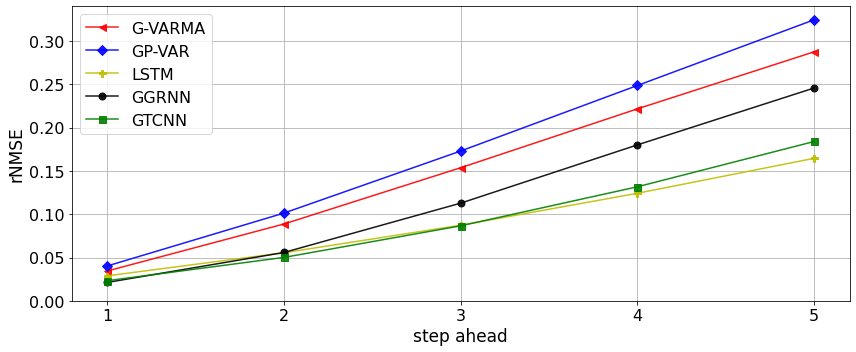

In [6]:
g_varma_rNMSEs = [0.0344, 0.0887, 0.1537, 0.2217, 0.2876]
gp_var_rNMSEs = [0.0402, 0.1013, 0.1730, 0.2487, 0.3246]
lstm_rNMSEs = [0.0288, 0.0555, 0.0873, 0.1242, 0.1646] # std: [0.0004, 0.0009, 0.0041, 0.0098, 0.016]
GGRNN_rNMSEs = [0.0212, 0.0558, 0.1128, 0.1801, 0.2458] # std: [0.0007, 0.0022, 0.0079, 0.0143, 0.0194]
# GTCNN_rNMSEs = [0.021, 0.0468, 0.0795, 0.1154, 0.1511]


avg_GTCNN = [0.0232,
            0.0501,
            0.0866,
            0.1317,
            0.184] # feat: 4, 8 | nodes: 1, 0.5

ax = plt.figure(figsize=(12, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.plot(steps_ahead, GTCNN_rNMSEs, 'g', marker='s', label='GTCNN')
alpha = 0.9
mksize= 7
plt.plot(steps_ahead, g_varma_rNMSEs, 'r', marker='<', label='G-VARMA', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, gp_var_rNMSEs, 'b', marker='D', label='GP-VAR', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, lstm_rNMSEs, 'y', marker='P', label='LSTM', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, GGRNN_rNMSEs, 'black', marker='o', label='GGRNN', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, avg_GTCNN, 'green', marker='s', label='GTCNN', markersize=mksize, alpha=alpha)


plt.xlabel("step ahead", fontsize=17)
plt.ylabel("rNMSE", fontsize=17)
plt.legend(fontsize=16)
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.grid()
plt.ylim(0, 0.34)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

# 
plt.savefig("C:\\Users\\gabri\\Desktop\\noaa_results_new.pdf")
plt.tight_layout()
plt.show()


# print(figure_dir + name.split('\\')[-1] + f"_typeOfSort={type_of_sort}_rank={model_number}.png")

# Insample experiments

In [7]:
# percentages = [2.5, 5, 15, 25, 35]
# LSTM_rNMSEs = [0.0365, 0.034, 0.0309, 0.0298, 0.0288,]
# GTCNN_rNMSEs = [0.0435, 0.0425, 0.0322, 0.028, 0.0232]
# GGRNN_rNMSEs = [0.0344, 0.0332, 0.0279, 0.0227, 0.0212,]

# ax = plt.figure(figsize=(12, 5)).gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.plot(percentages, GTCNN_rNMSEs, 'g', marker='s', label='GTCNN')
# # plt.plot(steps_ahead, g_varma_rNMSEs, 'r', marker='<', label='G-VARMA')
# # plt.plot(steps_ahead, gp_var_rNMSEs, 'b', marker='D', label='GP-VAR')
# plt.plot(percentages, LSTM_rNMSEs, 'y', marker='P', label='LSTM')
# plt.plot(percentages, GGRNN_rNMSEs, 'black', marker='o', label='GGRNN')

# plt.xlabel("in-sample %", fontsize=17)
# plt.ylabel("1-step rNMSE", fontsize=17)
# plt.legend(fontsize=16)
# #plt.title(name.split("_")[start-5:], fontsize=16)
# plt.grid()
# plt.ylim(0, 0.06)
# plt.yticks(fontsize=16)
# plt.xticks(fontsize=16)

# # 
# plt.savefig("C:\\Users\\gabri\\Desktop\\noaa_insample_experiment.png")
# plt.tight_layout()
# plt.show()

# Ablation study

In [8]:
folder_path = r"C:\Users\gabri\Desktop\new_thesis_project\prediction\NOAA\ablation_study"
folders = [f for f in next(os.walk(folder_path))[1] if "__" not in f]

for fold in folders:
    result_file = os.path.join(folder_path, fold, 'results.json')
    if os.path.exists(result_file):
        with open(result_file, 'r') as f:
            results = json.load(f)['final_res']
            print(f"{fold} --> Means: {results['avg']} | Stds: {results['std']}")

CARTESIAN --> Means: [0.0293, 0.0655, 0.1113, 0.1586, 0.2077] | Stds: [0.0013, 0.0034, 0.0074, 0.0125, 0.0195]
PARAMETRIC --> Means: [0.0277, 0.0622, 0.1066, 0.1569, 0.2083] | Stds: [0.004, 0.0075, 0.012, 0.0144, 0.0164]
STRONG --> Means: [0.0271, 0.0605, 0.1077, 0.1667, 0.2279] | Stds: [0.0027, 0.0048, 0.0048, 0.0091, 0.0177]


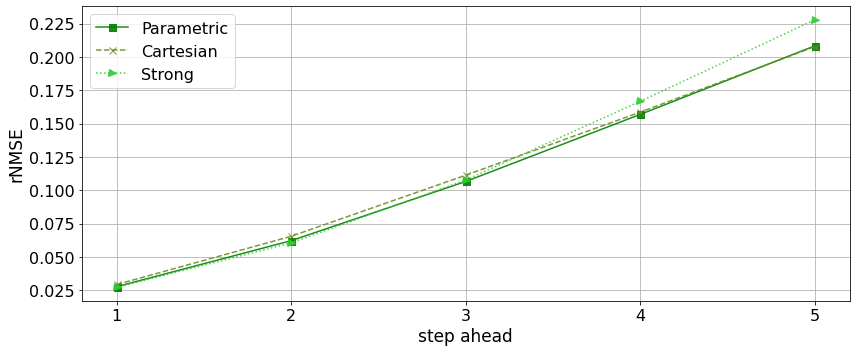

In [42]:
cartesian_rNMSEs = [ 0.0293, 0.0655, 0.1113, 0.1586, 0.2077 ]
parametric_rNMSEs = [ 0.0277, 0.0622, 0.1066, 0.1569, 0.2083 ]
strong_rNMSEs = [ 0.0271, 0.0605, 0.1077, 0.1667, 0.2279 ]

ax = plt.figure(figsize=(12, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

alpa=0.95
plt.plot(steps_ahead, parametric_rNMSEs, 'g', marker='s', label='Parametric', markersize=mksize, alpha=alpha)
plt.plot(steps_ahead, cartesian_rNMSEs, 'olivedrab', marker='x', label='Cartesian', markersize=mksize, alpha=alpha, linestyle="--")
plt.plot(steps_ahead, strong_rNMSEs, 'limegreen', marker='>', label='Strong', markersize=mksize, alpha=alpha, linestyle=":")



plt.xlabel("step ahead", fontsize=17)
plt.ylabel("rNMSE", fontsize=17)
plt.legend(fontsize=16)
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.grid()
# plt.ylim(0, 0.06)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

# 
plt.savefig("C:\\Users\\gabri\\Desktop\\noaa_ablation_experiment.pdf")
plt.tight_layout()
plt.show()

In [1]:
# Increases

In [9]:
# relative
def get_relative_deltas(values_list):
    one_step_error = values_list[0]
    new_values = []
    for error in values_list[1:]:
        new_values.append( (error-one_step_error) / one_step_error * 100)
    return new_values

g_varma_deltas = get_relative_deltas(g_varma_rNMSEs)
gp_var_deltas = get_relative_deltas(gp_var_rNMSEs)
lstm_deltas = get_relative_deltas(lstm_rNMSEs)
GGRNN_deltas = get_relative_deltas(GGRNN_rNMSEs)
avg_GTCNN_deltas = get_relative_deltas(avg_GTCNN)

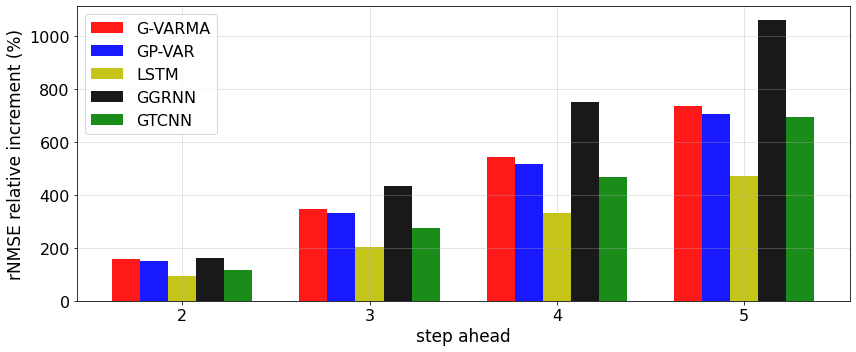

In [11]:
ax = plt.figure(figsize=(12, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ind = np.arange(len(g_varma_deltas))  # the x locations for the groups
width = 0.15  # the width of the bars

alpha = 0.9
rects1 = ax.bar(ind - 2*width, g_varma_deltas, width, color='r', label='G-VARMA', alpha=alpha)
rects2 = ax.bar(ind - width, gp_var_deltas, width, color='b', label='GP-VAR', alpha=alpha)
rects3 = ax.bar(ind, lstm_deltas, width, color='y', label='LSTM', alpha=alpha)
rects4 = ax.bar(ind + width, GGRNN_deltas, width, color='black', label='GGRNN', alpha=alpha)
rects5 = ax.bar(ind + 2*width, avg_GTCNN_deltas, width, color='g', label='GTCNN', alpha=alpha)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rNMSE increase')
ax.set_xticks(ind)
ax.set_xticklabels(('2', '3', '4', '5'), fontsize=17)
ax.legend()
plt.grid(alpha=0.4)

plt.xlabel("step ahead", fontsize=17)
plt.ylabel("rNMSE relative increment (%)", fontsize=17)
plt.legend(fontsize=16, loc="upper left")
#plt.title(name.split("_")[start-5:], fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# plt.ylim()


plt.tight_layout()

plt.savefig("C:\\Users\\gabri\\Desktop\\noaa_increases.pdf")


plt.show()